Discrete Sim of lost person dynamics

inputs:
- landscape: some array of coordinates, each cell with
    - elevation
    - amount of linear-feature-ness
- Person:
    - gets tired, store energy
    - profiles
        - random
        -


In [134]:
!pip install noise
!pip install rasterio

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.1.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.1.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [135]:
import numpy as np
import matplotlib.pyplot as plt
from noise import pnoise2 # just for realistic elevation generation
import matplotlib.patches as mpatches
import cv2
import rasterio
np.random.seed(0)

In [260]:
class Agent:
    def __init__(self, start_position, profile=[1, 0, 0, 0, 0, 0]):
        new_position = self.calculate_second_position(start_position)
        self.previous_position = start_position
        self.position = new_position
        self.profile = profile
        self.history = [tuple(start_position), tuple(new_position)]
        self.backtrack_history = []
        self.velocity = new_position - start_position
        self.alpha = np.array([0.55, 0.55])

    def calculate_second_position(self, first_pos):
        possible_directions = [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (1, 1), (-1, 1), (1, -1)]
        direction = np.array(possible_directions[np.random.choice(len(possible_directions))])
        new_position = first_pos + direction
        return new_position
    
    def update_velocity_and_position(self, provisional_position, landscape):
        self.velocity = provisional_position - self.position
        
        # x(t + 1) = (2 − α)x(t) + (α − 1)x(t − 1) + αv(t)
        new_position = (2 - self.alpha) * self.position + (self.alpha - 1) * self.previous_position + self.alpha * self.velocity
        
        self.previous_position = self.position.copy()
        
        new_position = np.round(new_position).astype('uint16')
        self.position = np.clip(new_position, 0, landscape.size - 1)
        self.history.append(tuple(self.position))

    def random_walk(self, landscape):
        direction = np.random.randint(-1, 2, size=2)
        new_position = self.position + direction
        new_position = np.clip(new_position, 0, landscape.size - 1)
        return new_position

    def route_travel(self, landscape):
        velocity_directions = [(self.velocity[0], self.velocity[1])]
        candidates = []

        
        if velocity_directions == [(1, 0)]:
            velocity_directions.extend([(1, 1), (1, -1)])
        elif velocity_directions == [(-1, 0)]:
            velocity_directions.extend([(-1, 1), (-1, -1)])
        elif velocity_directions == [(0, 1)]:
            velocity_directions.extend([(1, 1), (-1, 1)])
        elif velocity_directions == [(0, -1)]:
            velocity_directions.extend([(1, -1), (-1, -1)])
        elif velocity_directions == [(1, 1)]: 
            velocity_directions.extend([(0, 1), (1, 0)])
        elif velocity_directions == [(-1, -1)]:
            velocity_directions.extend([(-1, 0), (0, -1)])
        elif velocity_directions == [(-1, 1)]: 
            velocity_directions.extend([(-1, 0), (0, 1)])
        elif velocity_directions == [(1, -1)]: 
            velocity_directions.extend([(1, 0), (0, -1)])

        for dx, dy in velocity_directions:
            nx, ny = self.position[0] + dx, self.position[1] + dy
            nx = round(nx)
            ny = round(ny)
            if 0 <= nx < landscape.size and 0 <= ny < landscape.size:
                if landscape.linear_features[nx, ny] == 1:
                    candidates.append((nx, ny))
        if candidates:
            chosen_position = np.random.choice(len(candidates))
            new_position = np.array(candidates[chosen_position])
            return new_position
        else:
            return self.random_walk(landscape)

    def direction_travel(self, landscape):
        new_position = self.position + self.velocity
        new_position = np.clip(new_position, 0, landscape.size - 1)
        return new_position

    def stay_put(self, landscape):
        return self.position

    def view_enhance(self, landscape):
        directions = [(0, 1), (0, -1), (1, 0), (-1, 0), (1, 1), (1, -1), (-1, 1), (-1, -1)]
        current_x, current_y = self.position
        current_elevation = landscape.elevation[current_x, current_y]
        best_position = self.position
        best_elevation = current_elevation
        for dx, dy in directions:
            nx, ny = current_x + dx, current_y + dy
            if 0 <= nx < landscape.size and 0 <= ny < landscape.size:
                elevation = landscape.elevation[nx, ny]
                if elevation > best_elevation:
                    best_position, best_elevation = [nx, ny], elevation
        new_position = np.array(best_position)
        return new_position
    
    def backtrack(self, landscape):
        if len(self.history) > 1:
            self.backtrack_history.append(self.history.pop())
            new_position = np.array(self.history[-1])
            return new_position
        else:
            return self.position

    def reset(self):
        self.history = [tuple(self.position)]

import cv2
import numpy as np
import rasterio

class Landscape:
    def __init__(self, size, rgb_image_path=None, depth_image_path=None):
        self.size = size
        if rgb_image_path and depth_image_path:
            rgb_image = self.load_rgb_image(rgb_image_path)
            depth_image = self.load_depth_image(depth_image_path)
            self.rgb_image_cropped = self.crop_center(rgb_image, size, size)
            depth_image_cropped = self.crop_center(depth_image, size, size)
            self.elevation = self.process_depth(depth_image_cropped)
            self.linear_features = self.detect_linear_features(self.elevation)
            self.inaccessible_mask = self.detect_water_in_rgb(self.rgb_image_cropped)
        else:
            self.elevation = self.generate_elevation()
            self.linear_features = self.generate_linear_features()
            self.inaccessible_mask = self.generate_inaccessible_features()

    def load_rgb_image(self, rgb_image_path):
        rgb_image = cv2.imread(rgb_image_path, cv2.IMREAD_COLOR)
        if rgb_image is None or rgb_image.shape[2] != 3:
            raise ValueError("Invalid RGB image. Ensure the image is 3-channel (RGB).")
        rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB)
        return rgb_image

    def load_depth_image(self, depth_image_path):
        with rasterio.open(depth_image_path) as dataset:
            depth_image = dataset.read(1).astype(np.float32)
        return depth_image

    def crop_center(self, img, cropx, cropy):
        y, x = img.shape[:2]
        startx = x // 2 - (cropx // 2)
        starty = y // 2 - (cropy // 2)
        return img[starty:starty+cropy, startx:startx+cropx]

    def process_depth(self, depth_image):
        depth_resized = cv2.resize(depth_image, (self.size, self.size))
        normalized_depth = (depth_resized - depth_resized.min()) / (depth_resized.max() - depth_resized.min())
        return normalized_depth

    def detect_linear_features(self, elevation):
        edges = cv2.Canny((elevation * 255).astype(np.uint8), 100, 200)
        linear_features = cv2.resize(edges, (self.size, self.size)).astype(np.float32) / 255
        return linear_features

    def detect_water_in_rgb(self, rgb_image):
        # Assuming water is represented by blueish color, we use a range for blue.
        lower_blue = np.array([0, 0, 100])  # Lower bound for blue in RGB
        upper_blue = np.array([100, 150, 255])  # Upper bound for blue in RGB

        # Create a mask where the blueish areas are marked as 1, and others as 0
        mask = cv2.inRange(rgb_image, lower_blue, upper_blue)
        return mask

    def generate_elevation(self):
        # Placeholder: Generates random elevation data if no depth image is provided
        elevation = np.random.rand(self.size, self.size)
        return elevation

    def generate_linear_features(self):
        # Placeholder: Generates random linear features if no depth image is provided
        linear_features = np.random.rand(self.size, self.size)
        return linear_features

    def generate_inaccessible_features(self):
        # Placeholder: Generates random mask for inaccessible features
        inaccessible_features = np.random.rand(self.size, self.size)
        return inaccessible_features

    def generate_elevation(self):
        scale = 100.0
        octaves = 6
        persistence = 0.5
        lacunarity = 2.0
        elevation = np.zeros((self.size, self.size))
        for i in range(self.size):
            for j in range(self.size):
                elevation[i][j] = pnoise2(i / scale,
                                          j / scale,
                                          octaves=octaves,
                                          persistence=persistence,
                                          lacunarity=lacunarity,
                                          repeatx=self.size,
                                          repeaty=self.size,
                                          base=0)
        elevation = (elevation - elevation.min()) / (elevation.max() - elevation.min())
        return elevation

    def generate_linear_features(self):
        linear_features = np.zeros((self.size, self.size))
        num_lines = np.random.randint(5, 15)
        for _ in range(num_lines):
            x_start = np.random.randint(0, self.size)
            y_start = np.random.randint(0, self.size)
            line_length = np.random.randint(10, 20)
            direction = np.random.choice(['horizontal', 'vertical', 'diagonal'])
            for i in range(line_length):
                if direction == 'horizontal':
                    x = x_start + i
                    y = y_start
                elif direction == 'vertical':
                    x = x_start
                    y = y_start + i
                elif direction == 'diagonal':
                    x = x_start + i
                    y = y_start + (i // 2)
                if 0 <= x < self.size and 0 <= y < self.size:
                    linear_features[x, y] = 1
        return linear_features


    def visualize(self, agent_history):
        agent_history = np.array(agent_history)
        
        linear_features_repeated = np.repeat(np.reshape(self.inaccessible_mask, (self.size, self.size, 1)), 3, axis=-1)

        rgb_image_with_features = np.where(linear_features_repeated > 0, np.full_like(self.rgb_image_cropped, 255), self.rgb_image_cropped)

        plt.imshow(rgb_image_with_features, alpha=1, label="Image with Linear Features")

        plt.plot(agent_history[:, 1], agent_history[:, 0], 'b-', marker='o', markersize=3, label="Agent's Path")
        plt.plot(agent_history[0, 1], agent_history[0, 0], 'go', markersize=10, label="Start Point")
        plt.plot(agent_history[-1, 1], agent_history[-1, 0], 'ro', markersize=10, label="End Point")
        
        path_patch = mpatches.Patch(color='blue', label="Agent's Path")
        start_patch = mpatches.Patch(color='green', label='Start Point')
        end_patch = mpatches.Patch(color='red', label='End Point')
        plt.legend(handles=[path_patch, start_patch, end_patch],
                bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        
        plt.title("Linear Features with Agent's Path")
        plt.tight_layout()
        plt.show()



def simulate(landscape, agent, timesteps):
    agent.reset()
    for _ in range(timesteps):
        behavior_choice = np.random.choice(
            ['RW', 'RT', 'DT', 'SP', 'VE', 'BT'],
            p=agent.profile
        )
        if behavior_choice == 'RW':
            provisional_position = agent.random_walk(landscape)
        elif behavior_choice == 'RT':
            provisional_position = agent.route_travel(landscape)
        elif behavior_choice == 'DT':
            provisional_position = agent.direction_travel(landscape)
        elif behavior_choice == 'SP':
            provisional_position = agent.stay_put(landscape)
        elif behavior_choice == 'VE':
            provisional_position = agent.view_enhance(landscape)
        elif behavior_choice == 'BT':
            provisional_position = agent.backtrack(landscape)
        agent.update_velocity_and_position(provisional_position, landscape)
    agent.history.extend(agent.backtrack_history)
    landscape.visualize(agent.history) 

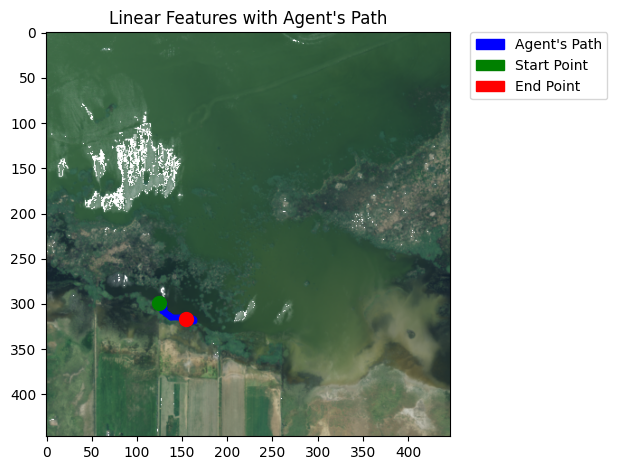

In [261]:
rgb_image_path = 'image.tif'  
depth_image_path = 'image_d.tif' 
landscape = Landscape(size=447, rgb_image_path=rgb_image_path, depth_image_path=depth_image_path)
agent = Agent(start_position=(300, 125), profile=[0, 1, 0, 0, 0, 0])

simulate(landscape, agent, timesteps=100)

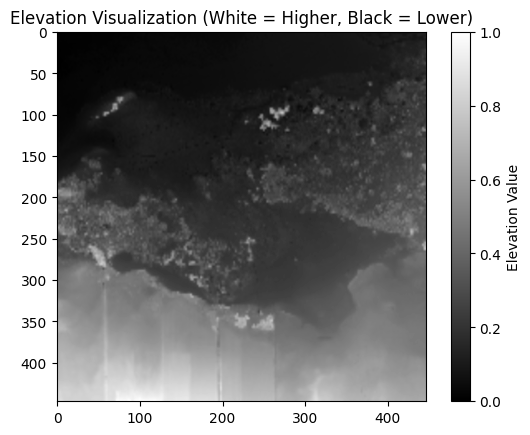

In [257]:
plt.imshow(landscape.elevation, cmap='gray')
plt.title('Elevation Visualization (White = Higher, Black = Lower)')
plt.colorbar(label='Elevation Value')
plt.show()